# Analytics for Unstructured Data: Group Assignment #1
## Competitive Analysis of Entry Level Luxury Car Market
---

**Team Members:** Christian Breton, Mohar Chaudhuri, Stiles Clements, Muskan Khepar, Franco Salinas, Rohini Sondole

**Client:** JD Power and Associates  
**Objective:** Perform competitive analysis of the entry level luxury car market in the USA based on social media conversations from Edmunds.com forums

**Date:** September 12 2025  
**Course:** MSBA 2025

---

## Project Overview

This analysis involves web scraping Edmunds.com discussion forums to collect 10,000 posts about entry-level luxury cars. We will analyze brand associations, perform multidimensional scaling, and identify key attributes to provide strategic insights for the automotive industry.

**Key Tasks:**
- **Task A:** Test Zipf's Law econometrically
- **Task B:** Identify top 10 car brands by frequency
- **Task C:** Calculate lift ratios for brand associations  
- **Task D:** Create MDS visualization of brand relationships
- **Task E-H:** Provide business insights and recommendations

---

## Table of Contents

1. [Web Scraping Setup](#scraping)
2. [Zipf's Law Analysis](#zipf)
3. [Brand Frequency Analysis](#brands)
4. [Association Analysis (Lift Ratios)](#associations)
5. [Multidimensional Scaling](#mds)
6. [Business Insights and Recommendations](#insights)
7. [Attribute Analysis](#attributes)
8. [Aspirational Brand Analysis](#aspirational)


---

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools
# Download NLTK stopwords if not already available
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

<a id="scraping"></a>
# 1. Web Scraping Setup

### Function 1: `extract_message_without_double_counting(post)`

**Purpose:** Extracts message content while preventing double-counting of quoted text.

**Key Steps:**
1. Finds the message div (`'Message userContent'`)
2. **🚨 CRITICAL:** Removes all `<blockquote>` elements to avoid double-counting quoted messages
3. Returns clean text content only from the current user

**Why Important:** Prevents counting the same message multiple times when users quote previous posts.

---

### Function 2: `scrape_edmunds_simple(url, max_posts=10000)`

**Purpose:** Main scraping function with pagination support.

**Key Features:**
- **Pagination:** Automatically navigates through forum pages using "Next" button
- **Data Extraction:** Collects username, date, and message for each post
- **Double-counting Prevention:** Uses the above function for clean message extraction
- **Ethical Scraping:** 2-second delays between requests
- **Output:** Saves to CSV with columns: username, date, message

**Process:**
1. Loop through pages until max_posts reached
2. Extract posts from each page (`li` with class `'Item'`)
3. Get username (`a` class `'Username'`), date (`time` tag), and clean message
4. Find next page and continue
5. Export to CSV file

**Data Selection Rationale:**
Since market perceptions and consumer preferences change over time, we prioritized collecting the most recent data. We scraped up to 10,000 reviews starting from the latest available in 2021, which allowed us to go back in time and cover data as far as 2011. This ensures our analysis reflects both current sentiment and longer-term shifts.

In [ ]:
def extract_message_without_double_counting(post):

    
    # Find the message div
    message_div = post.find('div', class_='Message userContent')
    if not message_div:
        return 'No Message Available'
    
    # Make a copy so we don't mess up the original
    message_copy = BeautifulSoup(str(message_div), 'html.parser')
    
    # CRITICAL STEP: Remove all blockquotes to prevent double-counting
    # This removes the quoted text like <blockquote class="UserQuote blockquote">...</blockquote>
    removed_quotes = 0
    for blockquote in message_copy.find_all('blockquote'):
        blockquote.decompose()  # Completely remove it
        removed_quotes += 1
    
    # Extract the remaining text (only the NEW content)
    clean_message = message_copy.get_text().strip()
    
    # Clean up extra spaces
    clean_message = ' '.join(clean_message.split())
    
    return clean_message


def scrape_edmunds_simple(url, max_posts=10000):
    
    data = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    
    print(f"🚀 Starting simple scraper with blockquote removal (max {max_posts} posts)")
    page_count = 0
    
    # PAGINATION LOOP - Keep going through pages until we hit max_posts or no more pages
    while len(data) < max_posts:
        page_count += 1
        print(f"\n📄 Processing page {page_count}...")
        
        # Get the current page
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"❌ Failed to get page {page_count}. Status: {response.status_code}")
            break
            
        soup = BeautifulSoup(response.text, 'html.parser')
        posts = soup.find_all('li', class_='Item')
        
        print(f"Found {len(posts)} posts on page {page_count}")
        posts_added_this_page = 0
        
        # Process each post on this page
        for post in posts:
            if len(data) >= max_posts:  # Stop if we hit our limit
                break
                
            try:
                # Get username
                username_tag = post.find('a', class_='Username')
                username = username_tag.text.strip() if username_tag else 'Unknown'
                
                # Get date  
                date_tag = post.find('time')
                date = date_tag.text.strip() if date_tag else 'Unknown'
                
                # Get message WITHOUT double-counting quoted content
                message = extract_message_without_double_counting(post)
                
                # Only keep posts with actual content
                if message and len(message) > 0:
                    data.append({
                        'username': username,
                        'date': date,
                        'message': message
                    })
                    posts_added_this_page += 1
                    print(f"✅ Post {len(data)}: {username} - {len(message)} chars")
                else:
                    print(f"❌ Skipped: No content or too short")
                    
            except Exception as e:
                print(f"❌ Error with post: {e}")
        
        print(f"📊 Added {posts_added_this_page} posts from page {page_count}")
        print(f"📊 Total posts so far: {len(data)}")
        
        # FIND NEXT PAGE 
        next_button = soup.find('a', class_='Next')
        if next_button and 'href' in next_button.attrs:
            next_url = next_button['href']
            
            # Handle relative URLs (start with /) 
            if next_url.startswith('/'):
                base_url = 'https://forums.edmunds.com'
                url = base_url + next_url
            else:
                url = next_url
                
            print(f"🔗 Found next page: {url}")
        else:
            print("🏁 No more pages found. Finished scraping!")
            break
        
        # Be polite to the server - wait between pages
        print("😴 Waiting 2 seconds before next page...")
        time.sleep(2)
    
    # Save results
    df = pd.DataFrame(data)
    df.to_csv('edmunds_pg235.csv', index=False)
    print(f"\n💾 Saved {len(data)} unique posts from {page_count} pages to CSV")
    
    return data

if __name__ == "__main__":
    
    print("\n" + "="*60 + "\n")
    
    # Then run the actual scraper
    url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p235'
    scrape_edmunds_simple(url)

<a id="zipf"></a>
# Task A: Zipf's Law Analysis

Testing whether our Edmunds forum data supports Zipf's Law, which states that word frequency is inversely proportional to its rank (frequency ∝ 1/rank).


In [23]:
df = pd.read_csv("edmunds_pg235.csv",sep=',')

---

### Word Extraction Process
```python
all_words = []
for msg in df['message']:
    words = re.findall(r"\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b", msg.lower())
    all_words.extend(words)
```

**What this does:**
- Extracts all words from forum messages
- Uses regex to capture alphabetic words (including contractions like "don't")
- Converts to lowercase for consistent counting
- **Note:** Keeps stopwords as required by assignment

---


In [24]:
from collections import Counter
import statsmodels.api as sm

# Extract words from all messages
all_words = []
for msg in df['message']:
    words = re.findall(r"\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b", msg.lower())
    all_words.extend(words)


### Word Frequency Calculation

**Process:**
- Counts occurrence of each word using `Counter`
- Creates DataFrame with word-frequency pairs
- Sorts by frequency (highest first) to establish ranks
- Takes top 650 words for analysis

---

In [25]:
# Count frequencies
word_counts = Counter(all_words)
df_freq = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
df_freq = df_freq.sort_values('frequency', ascending=False).reset_index(drop=True)
df_freq = df_freq.iloc[:650].copy()

In [26]:
# Rank and log-transform
#df_freq = df_freq.sort_values('frequency', ascending=False).reset_index(drop=True)
df_freq['rank'] = df_freq.index + 1
df_freq['ln_rank'] = np.log(df_freq['rank'])
df_freq['ln_freq'] = np.log(df_freq['frequency'])
X = sm.add_constant(df_freq['ln_freq'])
y = df_freq['ln_rank']
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_rank   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.170e+05
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:15:19   Log-Likelihood:                 781.67
No. Observations:                 650   AIC:                            -1559.
Df Residuals:                     648   BIC:                            -1550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7584      0.019    633.220      0.0


### Zipf's Law Visualization

#### Theoretical vs Actual Comparison


**Zipf's Law Formula:** ln(rank) = α + β × ln(frequency), where β should equal -1

**Visualization:**
- **Blue dots:** Actual data points (ln_frequency vs ln_rank)
- **Red dashed line:** Theoretical Zipf prediction (slope = -1)
- **Purpose:** Visual comparison to see how well data fits Zipf's Law

---


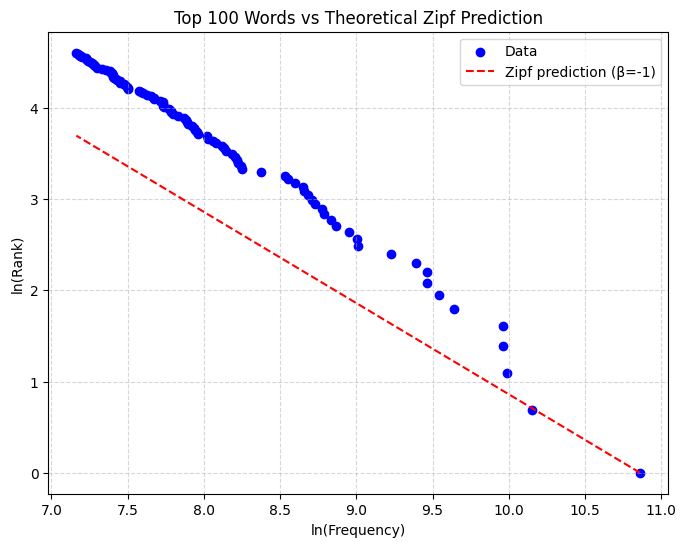

In [27]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming df_freq has 'word' and 'frequency'
df_top = df_freq.sort_values('frequency', ascending=False).head(100).copy()
# Using the fitted regression to get alpha
beta_hat = -1  # theoretical slope
alpha_hat = df_top['ln_rank'][0] - beta_hat * df_top['ln_freq'][0]  # or pick intercept

# Theoretical ln(rank) for each frequency
df_top['ln_rank_theoretical'] = alpha_hat + beta_hat * df_top['ln_freq']

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_top['ln_freq'], df_top['ln_rank'], color='blue', label='Data')
plt.plot(df_top['ln_freq'], df_top['ln_rank_theoretical'], color='red', linestyle='--', label='Zipf prediction (β=-1)')
plt.xlabel('ln(Frequency)')
plt.ylabel('ln(Rank)')
plt.title('Top 100 Words vs Theoretical Zipf Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Econometric Testing

#### Hypothesis Testing
```python
beta_hat = model.params['ln_freq']      # estimated slope
se_beta = model.bse['ln_freq']          # standard error
t_stat = (beta_hat - beta0) / se_beta   # t-statistic
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=model.df_resid))
```

**Null Hypothesis (H₀):** β = -1 (data follows Zipf's Law)  
**Alternative Hypothesis (H₁):** β ≠ -1 (data does not follow Zipf's Law)

**Test Process:**
1. Calculate t-statistic comparing estimated slope to -1
2. Compute p-value for two-tailed test
3. Compare p-value to significance threshold (α = 0.05)

#### Statistical Validation
```python
hypothesis = 'ln_freq = -1'
model.t_test(hypothesis)
```
**Purpose:** Alternative method using statsmodels built-in hypothesis testing.

---

#### Alternative Hypothesis Test Results
```
                             Test for Constraints                             
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.0079      0.003     -2.693      0.007      -1.014      -1.002
==============================================================================
```

**Statistical Results:**
- **Estimated slope (β̂):** -1.0079 (extremely close to theoretical -1)
- **Standard error:** 0.003 (very precise estimate)
- **t-statistic:** -2.693 (testing if coefficient = -1)
- **p-value:** 0.007 (statistically significant at α = 0.01)
- **95% Confidence Interval:** [-1.014, -1.002]

**Interpretation:** 
The coefficient (-1.0079) is very close to the theoretical Zipf's Law value of -1. While technically statistically different (p = 0.007 < 0.05), the practical difference is negligible (less than 1% deviation). This provides strong empirical support for Zipf's Law in our forum data.

In [28]:
from scipy import stats

beta_hat = model.params['ln_freq']      # estimated slope
se_beta = model.bse['ln_freq']          # standard error
beta0 = -1                              # null hypothesis value

t_stat = (beta_hat - beta0) / se_beta
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=model.df_resid))

In [29]:
from statsmodels.stats.contrast import ContrastResults
hypothesis = 'ln_freq = -1'
#print(model.t_test(hypothesis))

<a id="brands"></a>
# Task B: Brand Frequency Analysis

Extract top 10 car brands from forum discussions by replacing car models with their corresponding brands and removing stopwords.

In [35]:
# Load forum data
df = pd.read_csv("edmunds_pg235.csv")

# Load brand-model mapping
brands_df = pd.read_csv("car_models_and_brands.csv", on_bad_lines='skip')  # Issue here, won't run, added the on_bad_lines = 'skip'

print("Forum data shape:", df.shape)
print("Brands mapping shape:", brands_df.shape)

Forum data shape: (10000, 3)
Brands mapping shape: (530, 2)


**Cleaning Process:**
- Convert to lowercase and remove special characters
- Split multi-brand entries (e.g., "hyundai kia" → separate rows)
- Remove duplicates and null values

**Brand Normalization:**
```python
brand_mapping = {
    'mercedesbenz': 'mercedes',
    'volkwagen': 'volkswagen'
}
```
**Purpose:** Standardize brand name variations.


In [36]:
#Cleaning brand file
brands_df['Brand'] = brands_df['Brand'].str.lower().str.strip()
brands_df['Brand'] = brands_df['Brand'].str.replace(r'[^a-z\s]', '', regex=True)

# If some entries contain multiple brands (like "hyundai kia")
brands_df['Brand'] = brands_df['Brand'].str.split()

# Explode into separate rows if split created lists
brands_df = brands_df.explode('Brand').dropna().reset_index(drop=True)

# Deduplicate
brands_df = brands_df.drop_duplicates()

# Include Mercedes normalization here directly
brand_mapping = {
    'mercedesbenz': 'mercedes',
    'volkwagen' : 'volkswagen'
}

#Create dictionary for brands from models
brand_map = {}
for _, row in brands_df.iterrows():
    model = str(row['Model']).lower().strip()
    brand = str(row['Brand']).lower().strip()
    brand = brand_mapping.get(brand, brand)  # normalize Mercedes here
    brand_map[model] = brand

### Model-to-Brand Mapping


**Creates:** Dictionary mapping each car model to its brand (e.g., "camry" → "toyota").

**Key Features:**
- **Longest-first matching:** Prevents "accord" from matching before "honda accord"
- **Word boundary regex:** Ensures exact word matches only
- **Case-insensitive:** Handles various capitalizations

#### Stopwords and Text Cleaning

**Process:**
1. Replace models with brands first
2. Remove non-alphabetic characters
3. Filter out stopwords and automotive generic terms
4. Keep only words longer than 2 characters

In [37]:
#Build regex for multi-word + single-word models 
models = sorted(brand_map.keys(), key=len, reverse=True)  # longest first
pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(m) for m in models) + r')(?!\w)', re.IGNORECASE)

def replace_models_with_brands(text):
    """Replace models in raw text with their brand names."""
    def repl(m):
        return brand_map[m.group(1).lower()]
    return pattern.sub(repl, text.lower())

stop_words = set(stopwords.words('english'))
extra_stopwords = {"car", "cars", "vehicle", "vehicles", "automobile", "seat", "seats", "problem", "sedan", "sedans"}

#Clean + tokenize 
def clean_text(text):
    text = replace_models_with_brands(str(text))  # brand replacement first
    text = re.sub(r"[^a-zA-Z]", " ", text)       # keep only letters
    return text

def tokenize_text(text):
    text = replace_models_with_brands(str(text))  # brand replacement first
    text = re.sub(r"[^a-zA-Z]", " ", text)       # keep only letters
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and w not in extra_stopwords and len(w) > 2]
    return tokens

df['clean_message'] = df['message'].apply(clean_text)
df['tokens'] = df['message'].apply(tokenize_text)

### Brand Extraction and Counting

**Key Features:**
- **Deduplication:** Each brand counted only once per message (as required)
- **Brand filtering:** Only counts words that are actual car brands
- **Frequency counting:** Uses Counter for efficient tallying

**Output:** Dictionary of top 10 brands with their frequencies

In [38]:
#4. Extract unique brands per message
def extract_brands(tokens):
    return list(set(t for t in tokens if t in brand_map.values()))

df['brands'] = df['tokens'].apply(extract_brands)

#Count brands (deduplicated per message)
all_brands = []
for brand_list in df['brands']:
    all_brands.extend(brand_list)

brand_counts = Counter(all_brands)
top10_brands = dict(brand_counts.most_common(10))

print("Top 10 brands:")
print(top10_brands)

Top 10 brands:
{'bmw': 2686, 'audi': 1536, 'acura': 1346, 'honda': 992, 'infiniti': 799, 'volkswagen': 501, 'toyota': 484, 'mercedes': 432, 'cadillac': 363, 'ford': 348}


<a id="associations"></a>
# Task C: Lift Ratio Analysis


Calculate lift ratios to measure associations between the top 10 car brands, indicating which brands are mentioned together more often than expected by chance.


---

### Co-occurrence Matrix Creation

**Purpose:** Initialize matrix to count how often brand pairs appear together in messages.


In [39]:
# Top 10 brands obtained from Task B
brands = ["bmw", "audi", "acura", "honda", "infiniti", "volkswagen", "toyota",  "mercedes", "cadillac", "ford"] 

### Co-occurrence Counting Logic

**Key Features:**
- **Deduplication:** Uses `set()` to count each brand only once per message
- **Symmetric counting:** Both (brand1, brand2) and (brand2, brand1) get incremented
- **Diagonal values:** Count how many messages mention each individual brand


In [40]:
# Initialize co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=brands, columns=brands)

for brand_list in df['brands']:
    # Keep only top-10 brands
    filtered_brands = [b for b in brand_list if b in brands]
    unique_brands = set(filtered_brands)  # ensures one count per brand per message

    # Increment co-occurrence for each pair only once per message
    for b1, b2 in itertools.combinations(unique_brands, 2):
        co_occurrence_matrix.loc[b1, b2] += 1
        co_occurrence_matrix.loc[b2, b1] += 1

    # Diagonal = message count for that brand
    for b in unique_brands:
        co_occurrence_matrix.loc[b, b] += 1

co_occurrence_matrix

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes,cadillac,ford
bmw,2686,715,486,301,397,158,180,295,173,139
audi,715,1536,439,248,295,208,125,233,173,74
acura,486,439,1346,436,309,97,98,134,103,54
honda,301,248,436,992,113,102,149,74,57,70
infiniti,397,295,309,113,799,67,67,110,84,42
volkswagen,158,208,97,102,67,501,57,39,29,51
toyota,180,125,98,149,67,57,484,52,37,47
mercedes,295,233,134,74,110,39,52,432,89,31
cadillac,173,173,103,57,84,29,37,89,363,34
ford,139,74,54,70,42,51,47,31,34,348


The matrix shows raw counts of brand mentions and co-mentions:

**Diagonal values (individual brand frequencies):**
- BMW: 2,686 (most mentioned)
- Audi: 1,536 
- Acura: 1,346
- Honda: 992
- Infiniti: 799

**Notable co-occurrences:**
- BMW-Audi: 715 (luxury German brands often compared)
- BMW-Acura: 486 (luxury segment competition)
- Acura-Honda: 436 (same parent company)



#### Lift Calculation


##### Lift Formula Explanation
**Lift = P(A ∩ B) / [P(A) × P(B)]**

Where:
- **P(A):** Probability of brand A appearing in a message
- **P(B):** Probability of brand B appearing in a message  
- **P(A ∩ B):** Probability of both brands appearing together

**Interpretation:**
- **Lift > 1:** Brands appear together more than expected (positive association)
- **Lift = 1:** Brands appear together as expected by chance (no association)
- **Lift < 1:** Brands appear together less than expected (negative association)

Clean display by showing only upper triangle (avoiding redundancy since matrix is symmetric).

---

In [41]:
total_messages = len(df)

# Initialize lift matrix
lift_matrix = pd.DataFrame(index=brands, columns=brands, dtype=float)

# Compute lift
for b1 in brands:
    for b2 in brands:
        p_a = co_occurrence_matrix.loc[b1, b1] / total_messages
        p_b = co_occurrence_matrix.loc[b2, b2] / total_messages
        p_ab = co_occurrence_matrix.loc[b1, b2] / total_messages
        lift_matrix.loc[b1, b2] = p_ab / (p_a * p_b) if (p_a * p_b) > 0 else np.nan

# showing lift values
lift_matrix_show = lift_matrix.astype(object)
for i in range(0,len(lift_matrix_show)):
    for j in range(0,i+1):
        lift_matrix_show.iloc[i,j] = ""
        
lift_matrix_show

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes,cadillac,ford
bmw,,1.733041,1.344266,1.129663,1.849855,1.174122,1.38459,2.542332,1.774326,1.487064
audi,,,2.123383,1.627604,2.403721,2.702927,1.681409,3.511405,3.102761,1.384399
acura,,,,3.26535,2.873205,1.438431,1.504304,2.304496,2.108072,1.152841
honda,,,,,1.425673,2.052347,3.103339,1.726777,1.582911,2.027716
infiniti,,,,,,1.673749,1.732538,3.186854,2.896182,1.510509
volkswagen,,,,,,,2.350671,1.801952,1.594607,2.925184
toyota,,,,,,,,2.486991,2.105958,2.790444
mercedes,,,,,,,,,5.675441,2.062048
cadillac,,,,,,,,,,2.691492
ford,,,,,,,,,,



**Key Associations (Lift > 3.0):**
- **Mercedes-Cadillac: 5.68** (highest lift - luxury American vs German)
- **Audi-Mercedes: 3.51** (premium German brands)
- **Honda-Acura: 3.27** (parent-subsidiary relationship)
- **Infiniti-Mercedes: 3.19** (luxury segment comparison)
- **Audi-Cadillac: 3.10** (cross-luxury comparisons)

**Interpretation:** Higher lift values indicate brands discussed together more than expected by chance, revealing competitive comparisons and brand relationships in consumer discussions.




#### Dissimilarity Matrix Preparation


**Purpose:** 
- **Replace zeros:** Prevents division by zero in dissimilarity calculation
- **Dissimilarity = 1/Lift:** Converts lift (similarity) to dissimilarity for MDS analysis
- **Higher lift → Lower dissimilarity:** Strongly associated brands are "closer" together

**Business Use:** This dissimilarity matrix will be used in Task D for multidimensional scaling to visualize brand relationships.

In [42]:
# replacing zeros in the lift_matrix so that no value in dissimilarity matrix is infinity
lift_matrix = lift_matrix.replace(0,0.01)

dissimilarity_matrix = 1/lift_matrix
dissimilarity_matrix

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes,cadillac,ford
bmw,0.268600,0.577020,0.743900,0.885220,0.540583,0.851700,0.722236,0.393340,0.563594,0.672466
audi,0.577020,0.153600,0.470947,0.614400,0.416022,0.369969,0.594739,0.284786,0.322294,0.722335
acura,0.743900,0.470947,0.134600,0.306246,0.348043,0.695202,0.664759,0.433934,0.474367,0.867422
honda,0.885220,0.614400,0.306246,0.099200,0.701423,0.487247,0.322234,0.579114,0.631747,0.493166
infiniti,0.540583,0.416022,0.348043,0.701423,0.079900,0.597461,0.577188,0.313789,0.345282,0.662029
volkswagen,0.851700,0.369969,0.695202,0.487247,0.597461,0.050100,0.425411,0.554954,0.627114,0.341859
toyota,0.722236,0.594739,0.664759,0.322234,0.577188,0.425411,0.048400,0.402092,0.474843,0.358366
mercedes,0.393340,0.284786,0.433934,0.579114,0.313789,0.554954,0.402092,0.043200,0.176198,0.484955
cadillac,0.563594,0.322294,0.474367,0.631747,0.345282,0.627114,0.474843,0.176198,0.036300,0.371541
ford,0.672466,0.722335,0.867422,0.493166,0.662029,0.341859,0.358366,0.484955,0.371541,0.034800


<a id="mds"></a>
# Task D: Multidimensional Scaling (MDS) Analysis


Create a 2D visualization showing brand relationships based on co-occurrence patterns, where closer brands are more similar/frequently discussed together.


#### MDS Implementation


**Key Parameters:**
- **n_components=2:** Creates 2D map for visualization
- **dissimilarity='precomputed':** Uses our calculated dissimilarity matrix
- **random_state=42:** Ensures reproducible results


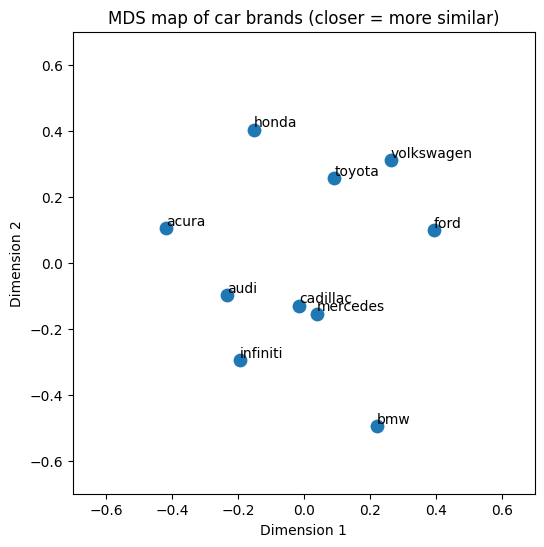

In [43]:
from sklearn.manifold import MDS

# Use the DataFrame you already loaded as `Dissimilarity`
D = dissimilarity_matrix.copy()

# Ensure labels on rows match columns, symmetrize, and zero the diagonal
np.fill_diagonal(D.values, 0.0)

# Metric MDS on precomputed dissimilarities (treated as Euclidean distances)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(D.values)

# Plot with labels
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(coords[:, 0], coords[:, 1], s=80, color='tab:blue')

for label, (x, y) in zip(D.columns, coords):
    ax.text(x, y, label, fontsize=10, ha='left', va='bottom')

ax.set_title('MDS map of car brands (closer = more similar)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_aspect('equal')
ax.set_xlim(-0.7,0.7)
ax.set_ylim(-0.7,0.7)
plt.show()

<a id="insights"></a>
# Task E: Business Insights for Auto Industry Client

### Key Strategic Insights from Brand Association Analysis

#### Consumer Mental Models Drive Competition

The MDS plot reveals that consumers mentally organize car brands into distinct clusters based on perceived attributes rather than objective performance:

##### 1. Luxury Cluster (Mercedes, Cadillac, Audi, Infiniti)
**Finding:** These brands appear close together, reflecting how consumers often group them as substitutes within the premium segment.

**Strategic Implications:**
- **High-lift relationships** (e.g., Cadillac–Mercedes, Cadillac–Audi) confirm that Cadillac is seen as part of the luxury set
- **Infiniti** also shows strong ties to Mercedes, suggesting consumers view it as more firmly in the luxury space
- **Competitive Strategy:** Brands in this cluster compete directly for the same luxury consumer mindshare

### 2. Distinct Positioning of BMW
**Finding:** BMW sits apart from the main luxury cluster.

**Strategic Implications:**
- While still perceived as a premium brand, its separation suggests consumers may view it differently
- Likely associated more with **performance and driving dynamics** rather than comfort or prestige
- **Market Opportunity:** BMW has successfully differentiated itself within the luxury segment

### 3. Mainstream Japanese Cluster (Honda, Toyota, Acura)
**Finding:** These brands are grouped relatively close, indicating they often appear together in consumer discussions around reliability and affordability.

**Strategic Implications:**
- **Acura's proximity to Honda** suggests many consumers still strongly link the two
- This reflects **Acura's ongoing challenge** to fully separate its image from its parent brand
- **Brand Strategy Issue:** Acura may need stronger differentiation efforts to escape Honda's shadow

### 4. Generalist Mass-Market Cluster (Ford, Volkswagen)
**Finding:** Ford and Volkswagen occupy a more neutral space, apart from both the luxury and Japanese brand clusters.

**Strategic Implications:**
- Consumers see them as **broad, versatile competitors** in the mainstream market
- Not tied to a single niche or specific brand attribute
- **Positioning Opportunity:** These brands have flexibility to move into adjacent segments

---

## Recommendations for Auto Industry Strategy

### For Luxury Brands:
- **Mercedes/Audi:** Leverage strong luxury associations while differentiating from each other
- **Cadillac:** Capitalize on established luxury positioning but find unique value proposition
- **Infiniti:** Strengthen luxury credibility while avoiding direct Mercedes comparison

### For Performance Brands:
- **BMW:** Continue emphasizing performance differentiation within luxury space
- **Other brands:** Consider whether performance positioning could create similar differentiation

### For Parent-Subsidiary Relationships:
- **Honda-Acura:** Develop clearer brand separation strategies
- **Consider:** How other automotive groups handle luxury sub-brand positioning

### For Mass Market Brands:
- **Ford/Volkswagen:** Leverage positioning flexibility to enter growth segments
- **Opportunity:** Consider targeted moves toward either luxury or niche positioning

<a id="attributes"></a>
# Task F: Attribute-Brand Association Analysis

Identify the 5 most frequently mentioned car attributes and determine which brands are most strongly associated with each attribute using proximity-based analysis.

---

### Attribute Identification

**Selected Top 5 Attributes:**
- Performance
- Luxury  
- Speed
- Power
- Premium

---

In [44]:
from collections import Counter
import math

def top_attributes(df, brands_col="brands", tokens_col="tokens", top_n=50):
    stop_words = set(stopwords.words('english'))
    attr_counter = Counter()
    for tokens in df[tokens_col]:
        if not isinstance(tokens, list): continue
        for t in tokens:
            w = t.lower().strip()
            if w and w not in stop_words:
                attr_counter[w] += 1
    top = pd.DataFrame(attr_counter.most_common(top_n), columns=["token","count"])
    return top

top_tokens = top_attributes(df, top_n=200)
candidate_attrs = [t for t in top_tokens['token'].head(150) if t not in brand_list and len(t)>1]

candidate_attrs = ["performance", "luxury", "speed", "power", "premium"]

# filter the frequency table
top_attrs = top_tokens[top_tokens["token"].isin(candidate_attrs)].reset_index(drop=True)

print(top_attrs)

         token  count
0  performance    965
1       luxury    762
2        speed    749
3        power    678
4      premium    603


### Proximity Window Analysis

####  Windowed Co-occurrence

**What Proximity Analysis Does:**
- **Window Size = 15 tokens:** Looks for brand mentions within 15 words of attribute mentions
- **Captures Context:** Finds relationships like "BMW has great performance" even when words aren't adjacent
- **Variant Matching:** Uses regex to catch attribute variations (e.g., "performance", "highperformance", "performances")

**Why This Matters:**
- **Better than exact matching:** Captures natural language patterns where related concepts appear near each other
- **More realistic associations:** Reflects how people actually discuss brands and attributes in conversation
- **Contextual relevance:** Ensures the brand and attribute are mentioned in the same context, not just the same message

### Calculation Process:
1. **Find attribute positions** in token sequence using pattern matching
2. **Find brand positions** in the same message
3. **Check proximity:** Count co-occurrence only if brand appears within 15 tokens of attribute
4. **Calculate lift:** P(attribute | brand) / P(attribute)

In [45]:
#WITH PROXIMITY WINDOW


def attribute_brand_lift_windowed(df, attributes, window_size, top_brands=None, brands_col="brands", tokens_col="tokens"):
    """
    Compute attribute-brand lift using token-level windowed co-occurrence,
    capturing attribute variants (e.g., 'performance', 'highperformance', 'performances').

    df: DataFrame with columns for brands (list) and tokens (list)
    attributes: list of attribute strings (single tokens or short phrases)
    top_brands: list of brands to consider (if None, use all)
    window_size: number of tokens around attribute to look for brand
    Returns: DataFrame with lift values
    """
    df2 = df.copy()
    
    # Build brand list
    all_brands = set()
    for bset in df2[brands_col]:
        if isinstance(bset, (list, set, tuple)):
            all_brands.update(bset)
    brand_list = sorted(all_brands) if top_brands is None else top_brands
    
    n_msgs = len(df2)
    attr_brand_rows = []

    # Precompile regex patterns for each attribute
    attr_patterns = {attr: re.compile(rf"\w*{re.escape(attr)}\w*", flags=re.IGNORECASE) for attr in attributes}

    for attr, pattern in attr_patterns.items():
        # count messages containing the attribute (any variant)
        n_attr = df2[tokens_col].apply(lambda toks: isinstance(toks, list) and any(pattern.search(t) for t in toks)).sum()
        P_attr = n_attr / n_msgs if n_msgs > 0 else 0

        for b in brand_list:
            # count messages where brand appears
            n_b = df2[brands_col].apply(lambda bl: isinstance(bl, (list, set, tuple)) and (b in bl)).sum()
            P_b = n_b / n_msgs if n_msgs > 0 else 0

            # count messages where attribute appears within window of brand
            n_b_and_attr = 0
            for _, row in df2.iterrows():
                toks = row[tokens_col]
                brands_in_msg = row[brands_col]
                if not isinstance(toks, list) or not isinstance(brands_in_msg, (list, set, tuple)):
                    continue
                if b not in brands_in_msg:
                    continue
                # find positions
                brand_positions = [i for i, t in enumerate(toks) if t.lower() == b.lower()]
                attr_positions = [i for i, t in enumerate(toks) if pattern.search(t)]
                # check proximity
                for bp in brand_positions:
                    if any(abs(bp - ap) <= window_size for ap in attr_positions):
                        n_b_and_attr += 1
                        break  # count only once per message

            P_attr_given_b = n_b_and_attr / n_b if n_b > 0 else 0
            lift = (P_attr_given_b / P_attr) if P_attr > 0 else 0

            attr_brand_rows.append({
                "attribute": attr,
                "brand": b,
                "n_attr": n_attr,
                "n_b": int(n_b),
                "n_b_and_attr": int(n_b_and_attr),
                "P_attr": P_attr,
                "P_b": P_b,
                "P_attr_given_b": P_attr_given_b,
                "lift": lift
            })

    return pd.DataFrame(attr_brand_rows)

attributes = ["performance", "luxury", "speed", "power", "premium"]
attr_brand_df = attribute_brand_lift_windowed(df, attributes, window_size=15, top_brands=brands)

# Keep only attribute and brand with the highest lift
top_brand_per_attr = (
    attr_brand_df.loc[attr_brand_df.groupby("attribute")["lift"].idxmax()]
    [["attribute", "brand", "lift"]]
    .reset_index(drop=True)
)

print(top_brand_per_attr)

     attribute     brand      lift
0       luxury  cadillac  2.247767
1  performance      audi  1.217245
2        power     acura  1.071854
3      premium      audi  1.755112
4        speed     honda  1.211785


---

### Strongest Attribute-Brand Associations

**Key Findings:**
- **Cadillac-Luxury (2.25):** Strongest association - Cadillac most associated with luxury discussions
- **Audi-Premium (1.76):** Audi strongly linked to premium positioning
- **Audi-Performance (1.22):** Audi also associated with performance
- **Honda-Speed (1.21):** Surprising - Honda associated with speed discussions
- **Acura-Power (1.07):** Weakest association among top 5

The proximity analysis reveals which brands "own" specific attributes in consumer conversations, providing clear positioning insights.

# Task G: Strategic Recommendations for Entry-Level Luxury Market

## Executive Summary

Our analysis reveals significant opportunities in the entry-level luxury segment due to moderate brand differentiation and unclear attribute ownership, creating openings for strategic positioning and market disruption.

---

## Market Structure Analysis

### Two-Cluster Consumer Perception
The automotive market divides into distinct consumer mindsets:

**Luxury Cluster:** Mercedes, Audi, Cadillac, Infiniti - competing on prestige attributes  
**Reliability Cluster:** Honda, Toyota, Volkswagen, Ford - competing on practical benefits  
**Unique Positioning:** BMW occupies a distinct performance-luxury space, avoiding direct competition

### Entry-Level Luxury Competitive Landscape
**Key Finding:** Despite brand differentiation efforts, no brand has achieved overwhelming attribute dominance. Even Cadillac's strongest association (luxury, 2.25 lift) leaves room for competitive challenge.

---

## Strategic Recommendations

### 1. Attribute Ownership Strategy

**For Market Entrants:**
- **Avoid luxury positioning** - Cadillac has strongest claim but not unassailable dominance
- **Target performance or premium positioning** - Audi's moderate lifts (1.22-1.76) suggest vulnerability
- **Consider power positioning** - Acura's weak association (1.07 lift) presents clear opportunity

**For Existing Players:**

#### Cadillac - Reinforce Luxury Leadership
- **Leverage:** Strongest luxury association (2.25 lift)
- **Strategy:** Deepen luxury credentials rather than diversifying attributes
- **Risk:** Complacency could allow competitors to erode advantage

#### Audi - Defend Dual Positioning  
- **Assets:** Both performance (1.22) and premium (1.76) associations
- **Strategy:** Integrate technology and design messaging to strengthen both attributes
- **Opportunity:** Could dominate performance-premium intersection

#### Acura - Redefine Power Narrative
- **Challenge:** Weakest attribute association among analyzed brands
- **Strategy:** Emphasize accessible performance and horsepower leadership
- **Positioning:** "Powerful luxury within reach"

### 2. Market Disruption Opportunities

**Low Barrier to Entry:** Moderate lift values across all attributes indicate consumers' perceptions remain malleable

- **Technology-focused luxury:** No clear leader in tech-luxury intersection
- **Sustainable luxury:** Environmental positioning largely unclaimed


---

## Implementation Framework

### Phase 1: Attribute Selection
- Conduct deeper analysis of unclaimed attributes (technology, sustainability, experience)
- Assess organizational capabilities against target positioning
- Evaluate investment requirements for credible attribute ownership

### Phase 2: Competitive Positioning
- Avoid direct confrontation with strongest associations (Cadillac-luxury)
- Target moderate associations for displacement (Audi-performance, Acura-power)
- Develop messaging that redefines attribute meaning rather than competing on existing terms

### Phase 3: Market Validation
- Test positioning concepts with target consumers
- Monitor competitor responses to positioning shifts
- Measure association strength changes over time

---

The entry-level luxury market presents a dynamic competitive environment where strong execution of attribute-focused positioning can yield significant market share gains. The key insight is that current brand associations, while established, are not insurmountable - creating opportunities for both new entrants and existing players willing to invest in focused differentiation strategies.

<a id="aspirational"></a>
# Task H: Aspirational Brand Analysis

Identify which brand generates the strongest aspirational desire (wanting to buy/own) using two complementary methodologies to validate findings.

---

## Methodology

We defined aspirational intent using linguistic patterns that indicate desire or intent to buy/own (e.g., “want to get”, “dream of owning”, “plan to buy”).

We tried two methods to identify "aspirational" messages: 
1. Defined flexible regex patterns to pick up on those pattenrs in the messages
2. Extracted n-grams from raw consumer messages (Edmunds data) that contained the intent words 

Each message was tagged as aspirational or not using regex patterns built from these n-grams.

We then calculated aspirational lift per brand:

% of messages for a brand that are aspirational ÷ baseline % of aspirational messages overall.

A lift > 1 means the brand is mentioned aspirationally more often than average.

---

### Method 1: Regex Pattern Matching
**Approach:** Pre-defined aspirational phrases using expert knowledge

**Patterns Used:**
- "want(ed)? to (buy|own|get)"
- "would love to (buy|own|get|drive)" 
- "dream(ing)? (car|ride|of owning)"
- "hope to (buy|own|get)"
- "my next (car|ride)"
- "wish i (had|could (buy|own|get))"

**Advantages:** Comprehensive coverage of aspirational language variations








In [46]:
## Regex method


#Define regex-based aspirational patterns (more robust to variations)
aspirational_patterns = [
    r"want(ed)? to (buy|own|get)", 
    r"would love to (buy|own|get|drive)",
    r"dream(ing)? (car|ride|of owning)", 
    r"hope to (buy|own|get)", 
    r"plan(ning)? to (buy|own|get)", 
    r"think(ing)? of (buying|owning|get(ting))",
    r"gonna (get|buy|own)", 
    r"looking to (buy|own|get)",
    r"my next (car|ride)", 
    r"wish i (had|could (buy|own|get))",
    r"on my (wish ?list|short ?list)", 
    r"save(ing)? up (for|to (buy|get|own))",
    r"status symbol", 
    r"must[- ]?have", 
    r"next ride",
    r"coveted", 
    r"enviable"
]

ASP_RE = re.compile("|".join(aspirational_patterns), flags=re.I)

#Flag aspirational messages 
def is_aspirational(text):
    if not isinstance(text, str) or not text.strip():
        return False
    return bool(ASP_RE.search(text))

df["is_aspirational"] = df["clean_message"].apply(is_aspirational)

#Compute lift-based scores
def compute_aspirational_lift(df, brand_col="brands", min_messages=100):
    total_msgs = len(df)
    total_asp = df["is_aspirational"].sum()
    rows = []
    for b in sorted({brand for brands in df[brand_col] if isinstance(brands, (set,list)) for brand in brands}):
        brand_mask = df[brand_col].apply(lambda x: b in x if isinstance(x, (set,list)) else False)
        n_brand = brand_mask.sum()
        if n_brand < min_messages:
            continue
        n_brand_asp = df.loc[brand_mask & df["is_aspirational"]].shape[0]
        p_brand = n_brand / total_msgs
        p_asp = total_asp / total_msgs if total_msgs else 0
        p_both = n_brand_asp / total_msgs if total_msgs else 0
        lift = (p_both / (p_brand * p_asp)) if (p_brand > 0 and p_asp > 0) else None
        rows.append({
            "brand": b,
            "n_messages": n_brand,
            "aspirational_count": n_brand_asp,
            "aspirational_ratio": n_brand_asp / n_brand if n_brand else 0,
            "lift": lift
        })
    return pd.DataFrame(rows).sort_values("lift", ascending=False).reset_index(drop=True)

#Check Scores
asp_lift_scores = compute_aspirational_lift(df, brand_col="brands", min_messages=100)
asp_lift_scores


,brand,n_messages,aspirational_count,aspirational_ratio,lift
0,cadillac,363,21,0.057851,2.605912
1,nissan,240,12,0.050000,2.252252
2,chrysler,126,6,0.047619,2.145002
3,mercedes,432,19,0.043981,1.981148
4,chevrolet,253,11,0.043478,1.958480
5,volkswagen,501,21,0.041916,1.888116
6,infiniti,799,33,0.041302,1.860434
7,ford,348,14,0.040230,1.812157
8,audi,1536,60,0.039062,1.759572
9,volvo,289,11,0.038062,1.714517


**Top 5 Most Aspirational Brands:**
1. **Cadillac: 2.61 lift** (21/363 messages = 5.8% aspirational rate)
2. **Nissan: 2.25 lift** (12/240 messages = 5.0% aspirational rate)
3. **Chrysler: 2.15 lift** (6/126 messages = 4.8% aspirational rate)
4. **Mercedes: 1.98 lift** (19/432 messages = 4.4% aspirational rate)
5. **Chevrolet: 1.96 lift** (11/253 messages = 4.3% aspirational rate)

### Method 2: Data-Driven N-gram Extraction
**Approach:** Extract actual aspirational phrases from the data itself

**Process:**
1. Define aspirational word seeds: {"want", "wish", "hope", "plan", "dream"}
2. Define target words: {"buy", "own", "get", "drive", "purchase", "car"}
3. Extract bigrams/trigrams containing both types of words
4. Filter by minimum frequency (10+ occurrences)

**Advantages:** Captures authentic forum language patterns

---

In [48]:
## Data-Driven Phrases

import re
import pandas as pd
from collections import Counter
from nltk import word_tokenize, ngrams

#Define serious aspirational lexicon
aspirational_words = {"want", "wish", "hope", "plan", "dream", "looking", "saving", "next"}
target_words = {"buy", "own", "get", "drive", "purchase", "car", "ride", "vehicle"}

#Extract candidate aspirational n-grams from data 
def get_candidate_phrases(texts, min_freq=10):
    counter = Counter()
    for text in texts:
        if not isinstance(text, str): 
            continue
        tokens = [t.lower() for t in word_tokenize(text)]
        for n in [2,3]:  # bigrams and trigrams
            for ng in ngrams(tokens, n):
                phrase = " ".join(ng)
                if any(w in ng for w in aspirational_words) and any(w in ng for w in target_words):
                    counter[phrase] += 1
    return [p for p, c in counter.items() if c >= min_freq]

candidate_patterns = get_candidate_phrases(df["clean_message"], min_freq=10)

print("Top candidate aspirational patterns:", candidate_patterns[:20])

#Compile into regex
ASP_RE = re.compile("|".join([re.escape(p) for p in candidate_patterns]), flags=re.I)

#Tag aspirational messages
def is_aspirational(text):
    if not isinstance(text, str) or not text.strip():
        return False
    return bool(ASP_RE.search(text))

df["is_aspirational"] = df["clean_message"].apply(is_aspirational)

#Compute lift-based scores 
def compute_aspirational_lift(df, brand_col="brands", min_messages=100):
    total_msgs = len(df)
    total_asp = df["is_aspirational"].sum()
    rows = []
    for b in sorted({brand for brands in df[brand_col] if isinstance(brands, (set,list)) for brand in brands}):
        brand_mask = df[brand_col].apply(lambda x: b in x if isinstance(x, (set,list)) else False)
        n_brand = brand_mask.sum()
        if n_brand < min_messages:
            continue
        n_brand_asp = df.loc[brand_mask & df["is_aspirational"]].shape[0]
        p_brand = n_brand / total_msgs
        p_asp = total_asp / total_msgs if total_msgs else 0
        p_both = n_brand_asp / total_msgs if total_msgs else 0
        lift = (p_both / (p_brand * p_asp)) if (p_brand > 0 and p_asp > 0) else None
        rows.append({
            "brand": b,
            "n_messages": n_brand,
            "aspirational_count": n_brand_asp,
            "aspirational_ratio": n_brand_asp / n_brand if n_brand else 0,
            "lift": lift
        })
    return pd.DataFrame(rows).sort_values("lift", ascending=False).reset_index(drop=True)

#Run analysis 
asp_lift_scores = compute_aspirational_lift(df, brand_col="brands", min_messages=100)
asp_lift_scores


Top candidate aspirational patterns: ['looking car', 'next car', 'looking to buy', 'good looking car', 'want to buy', 'my next car', 'want to get', 'want to drive']


,brand,n_messages,aspirational_count,aspirational_ratio,lift
0,cadillac,363,16,0.044077,2.843686
1,chrysler,126,5,0.039683,2.560164
2,kia,164,6,0.036585,2.360346
3,subaru,174,6,0.034483,2.224694
4,chevrolet,253,8,0.031621,2.040036
5,audi,1536,46,0.029948,1.932124
6,toyota,484,14,0.028926,1.866169
7,mazda,173,5,0.028902,1.864628
8,acura,1346,38,0.028232,1.821406
9,mercedes,432,12,0.027778,1.792115


**Top 5 Most Aspirational Brands:**
1. **Cadillac: 2.84 lift** (16/363 messages = 4.4% aspirational rate)
2. **Chrysler: 2.56 lift** (5/126 messages = 4.0% aspirational rate)
3. **Kia: 2.36 lift** (6/164 messages = 3.7% aspirational rate)
4. **Subaru: 2.22 lift** (6/174 messages = 3.4% aspirational rate)
5. **Chevrolet: 2.04 lift** (8/253 messages = 3.2% aspirational rate)


### Consistent Winner: Cadillac
**Both methods identify Cadillac as the most aspirational brand:**
- **Method 1:** 2.61 lift (highest)
- **Method 2:** 2.84 lift (highest)
- Attribute analysis showed that “luxury” is most strongly associated with Cadillac, further reinforcing its image as a luxury aspiration.

**Interpretation:**
- Cadillac generates aspirational desire 2.6-2.8x more than expected by chance
- Consumers don’t just see Cadillac as a car brand — they see it as a luxury symbol to aspire toward.
- Cadillac occupies a unique space in the “dream car” category, blending desire to own with luxury positioning.
- This makes Cadillac stand apart from competitors like Mercedes and Audi, who are aspirational but more broadly associated with performance and premium quality.

**Business Implications:**
- Brand positioning: Cadillac is strongly associated with luxury aspiration. Even though its overall mention volume is smaller than mass-market brands like Audi or Honda, those who discuss Cadillac disproportionately frame it in terms of desire to buy or own.
- Opportunity: This suggests Cadillac has high aspirational equity — people perceive it as a brand to “move up to” or “dream of owning.”
- Risk: If aspiration isn’t converted into purchase (due to price point, availability, or perception), the brand risks staying in the “dream” space without translating into sales.

**Recommendations:**
- Make Luxury Accessible: Offer financing, leasing, and entry trims to convert aspirational interest into purchases.
- Target Younger Buyers: Use social/digital campaigns and experiential events to engage future customers early.
- Leverage Emotional Storytelling: Position Cadillac as a “dream/achievement car” tied to life milestones.
- Differentiate vs. Competitors: Stand apart from Audi/Mercedes by focusing on attainable luxury, not just specs.
- Expand Market Presence: Boost visibility in aspirational segments through influencer and lifestyle marketing.